목표 : log-P를 예측해보자

log-p : 이온화 되지않은 화합물의 농도 비율


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#rdkit
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

#sklearn
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

## load_data

In [4]:
num_mols = 5000
f = open('./data/smiles.txt', 'r')
contents = f.readlines()

fps_total = []
logP_total = []

for i in range(num_mols):
    smi = contents[i].split()[0]
    m = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(m,2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp,arr)
    fps_total.append(arr)
    logP_total.append(MolLogP(m))
    
fps_total = np.asarray(fps_total)
logP_total = np.asarray(logP_total)

학습용 데이터와 테스트용 데이터를 나누자

In [5]:
num_total = fps_total.shape[0]
num_train = int(num_total*0.8)
num_test = num_total-num_train

num_total, num_train, num_test

(5000, 4000, 1000)

80%는 학습용, 나머지는 테스트용으로 사용하자. 그러면 각각 4000개 1000개 이다. 이제 분리하자

In [6]:
fps_train = fps_total[0:num_train]
logP_train = logP_total[0:num_train]
fps_test = fps_total[num_train:]
logP_test = logP_total[num_train:]

## Model

회귀 예측하기 위한 모델을 만들기 위해 SVR을 이용하자

커널은 5.0으로 하자

In [7]:
_gamma = 5.0
clf = SVR(kernel='poly', gamma=_gamma)
clf.fit(fps_train, logP_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5.0,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## 평가

정확도를 평가하기 위해 R2 socre와 MSE를 사용한다.

In [8]:
logP_pred = clf.predict(fps_test)
r2 = r2_score(logP_test, logP_pred)
mse = mean_squared_error(logP_test, logP_pred)
r2, mse

(0.7598955374744331, 0.40089623135693314)

## 시각화

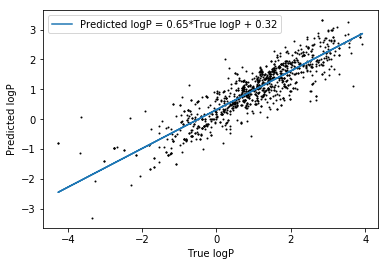

In [9]:
slope, intercept, r_value, p_value, std_error = stats.linregress(logP_test, logP_pred)
yy = slope*logP_test+intercept
plt.scatter(logP_test, logP_pred, color='black', s=1)
plt.plot(logP_test, yy, label='Predicted logP = '+str(round(slope,2))+'*True logP + '+str(round(intercept,2)))
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.legend()
plt.show()